In [1]:
import re
import os
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(2)
epochs = 2
batch_size = 1024
model_name = 'roberta-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/ai-cup-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/ai-cup-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/ai-cup-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48743 48743
12186 12186
15233 15233


In [10]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import TransformerEmbedding
kashgari.config.use_cudnn_cell = True

embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)
vocab_path = os.path.join(embedding_path, 'vocab.txt')
config_path = os.path.join(embedding_path, 'bert_config.json')
checkpoint_path = os.path.join(embedding_path, 'bert_model.ckpt')
embedding = TransformerEmbedding(vocab_path, 
                                 config_path, 
                                 checkpoint_path,
                                 bert_type='bert',
                                 sequence_length='auto',
                                 trainable=True,
                                 task='kashgari.LABELING',
                                )

model = BiLSTM_CRF_Model(embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-22 18:23:05,852 [DEBUG] kashgari - ------------------------------------------------
2020-12-22 18:23:05,852 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-22 18:23:05,853 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/roberta-chinese/bert_config.json
2020-12-22 18:23:05,853 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/roberta-chinese/vocab.txt
2020-12-22 18:23:05,854 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/roberta-chinese/bert_model.ckpt
2020-12-22 18:23:05,854 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unuse

Epoch 1/2
47/47 [==============================] - 42s 888ms/step - loss: 2.2396 - accuracy: 0.9027 - val_loss: 25.8714 - val_accuracy: 0.6536
Epoch 2/2
47/47 [==============================] - 38s 811ms/step - loss: 0.7713 - accuracy: 0.9586 - val_loss: 25.6542 - val_accuracy: 0.6693
CPU times: user 1min 18s, sys: 8.18 s, total: 1min 26s
Wall time: 2min 28s


In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-22 18:25:33,969 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 65
2020-12-22 18:25:34,092 [DEBUG] kashgari - predict seq_length: None, input: (2, 15233, 65)


477/477 [==============================] - 47s 98ms/step


2020-12-22 18:26:25,393 [DEBUG] kashgari - predict output: (15233, 65)
2020-12-22 18:26:25,394 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.3070    0.3235    0.3150       878
      med_exam     0.0000    0.0000    0.0000       134
          name     0.0000    0.0000    0.0000        88
      location     0.0000    0.0000    0.0000       102
         money     0.0000    0.0000    0.0000        43
       contact     0.0000    0.0000    0.0000        18
        family     0.0000    0.0000    0.0000        11
clinical_event     0.0000    0.0000    0.0000         1
            ID     0.0000    0.0000    0.0000         9
    profession     0.0000    0.0000    0.0000        17
     education     0.0000    0.0000    0.0000         2
  organization     0.0000    0.0000    0.0000         2
        others     0.0000    0.0000    0.0000         1

     micro avg     0.2064    0.2175    0.2118      1306
     macro avg     0.2064    0.2175    0.2118      1306



2020-12-22 18:27:38,142 [INFO] kashgari - model saved to /home/Danny/ai-cup-2020/danny/roberta/model/roberta-chinese_epoch_2_batch_1024


'/home/Danny/ai-cup-2020/danny/roberta/model/roberta-chinese_epoch_2_batch_1024'

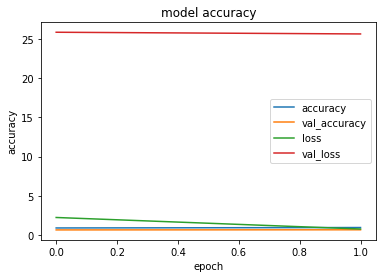

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [14]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [15]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [16]:
df = predicting_txt_to_dataframe('/home/Danny/ai-cup-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-22 18:27:38,305 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 24ms/step


2020-12-22 18:27:42,201 [DEBUG] kashgari - predict output: (70, 17)
2020-12-22 18:27:42,202 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:27:42,206 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-22 18:27:46,265 [DEBUG] kashgari - predict output: (131, 28)
2020-12-22 18:27:46,266 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:27:46,271 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 60ms/step


2020-12-22 18:27:50,608 [DEBUG] kashgari - predict output: (198, 47)
2020-12-22 18:27:50,609 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-22 18:27:50,612 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 40ms/step


2020-12-22 18:27:53,860 [DEBUG] kashgari - predict output: (96, 41)
2020-12-22 18:27:53,861 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:27:53,863 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 22ms/step


2020-12-22 18:27:54,003 [DEBUG] kashgari - predict output: (73, 17)
2020-12-22 18:27:54,004 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 0 1]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:27:54,010 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 42ms/step


2020-12-22 18:27:58,238 [DEBUG] kashgari - predict output: (266, 23)
2020-12-22 18:27:58,239 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-22 18:27:58,242 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 1s 144ms/step


2020-12-22 18:28:09,346 [DEBUG] kashgari - predict output: (308, 21)
2020-12-22 18:28:09,350 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:09,360 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 49ms/step


2020-12-22 18:28:18,934 [DEBUG] kashgari - predict output: (139, 38)
2020-12-22 18:28:18,935 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:18,937 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 36ms/step


2020-12-22 18:28:23,515 [DEBUG] kashgari - predict output: (167, 22)
2020-12-22 18:28:23,516 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:23,520 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 1s 59ms/step


2020-12-22 18:28:27,922 [DEBUG] kashgari - predict output: (272, 41)
2020-12-22 18:28:27,923 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:27,926 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 71ms/step


2020-12-22 18:28:32,247 [DEBUG] kashgari - predict output: (143, 63)
2020-12-22 18:28:32,248 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:32,256 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 62ms/step


2020-12-22 18:28:37,872 [DEBUG] kashgari - predict output: (663, 42)
2020-12-22 18:28:37,873 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:37,875 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 17ms/step


2020-12-22 18:28:42,135 [DEBUG] kashgari - predict output: (39, 25)
2020-12-22 18:28:42,138 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 36ms/step


2020-12-22 18:28:42,435 [DEBUG] kashgari - predict output: (175, 22)
2020-12-22 18:28:42,436 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:42,440 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 40ms/step


2020-12-22 18:28:42,722 [DEBUG] kashgari - predict output: (143, 28)
2020-12-22 18:28:42,723 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:42,726 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 27ms/step


2020-12-22 18:28:42,877 [DEBUG] kashgari - predict output: (88, 21)
2020-12-22 18:28:42,878 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:42,881 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 36ms/step


2020-12-22 18:28:43,102 [DEBUG] kashgari - predict output: (121, 28)
2020-12-22 18:28:43,103 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:43,105 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 31ms/step


2020-12-22 18:28:48,079 [DEBUG] kashgari - predict output: (85, 27)
2020-12-22 18:28:48,080 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:48,085 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 36ms/step


2020-12-22 18:28:52,282 [DEBUG] kashgari - predict output: (255, 19)
2020-12-22 18:28:52,283 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:52,288 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 43ms/step


2020-12-22 18:28:56,575 [DEBUG] kashgari - predict output: (202, 29)
2020-12-22 18:28:56,576 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:56,580 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 32ms/step


2020-12-22 18:28:56,875 [DEBUG] kashgari - predict output: (198, 19)
2020-12-22 18:28:56,876 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:28:56,879 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 45ms/step


2020-12-22 18:29:01,124 [DEBUG] kashgari - predict output: (102, 39)
2020-12-22 18:29:01,125 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 0 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:01,127 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 33ms/step


2020-12-22 18:29:05,578 [DEBUG] kashgari - predict output: (72, 36)
2020-12-22 18:29:05,579 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:05,584 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 44ms/step


2020-12-22 18:29:06,022 [DEBUG] kashgari - predict output: (246, 27)
2020-12-22 18:29:06,023 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:06,024 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 27ms/step


2020-12-22 18:29:09,962 [DEBUG] kashgari - predict output: (57, 34)
2020-12-22 18:29:09,963 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:09,965 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 29ms/step


2020-12-22 18:29:10,128 [DEBUG] kashgari - predict output: (82, 21)
2020-12-22 18:29:10,129 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:10,133 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 49ms/step


2020-12-22 18:29:15,043 [DEBUG] kashgari - predict output: (185, 32)
2020-12-22 18:29:15,044 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:15,047 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-22 18:29:15,316 [DEBUG] kashgari - predict output: (148, 28)
2020-12-22 18:29:15,317 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:15,323 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 39ms/step


2020-12-22 18:29:15,751 [DEBUG] kashgari - predict output: (281, 23)
2020-12-22 18:29:15,752 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:15,755 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 29ms/step


2020-12-22 18:29:19,730 [DEBUG] kashgari - predict output: (116, 20)
2020-12-22 18:29:19,731 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:19,735 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 38ms/step


2020-12-22 18:29:20,038 [DEBUG] kashgari - predict output: (168, 25)
2020-12-22 18:29:20,039 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:20,043 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 47ms/step


2020-12-22 18:29:24,390 [DEBUG] kashgari - predict output: (218, 30)
2020-12-22 18:29:24,391 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:24,393 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 39ms/step


2020-12-22 18:29:24,629 [DEBUG] kashgari - predict output: (123, 32)
2020-12-22 18:29:24,630 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:24,632 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 24ms/step


2020-12-22 18:29:24,768 [DEBUG] kashgari - predict output: (82, 21)
2020-12-22 18:29:24,769 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:24,772 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-22 18:29:24,910 [DEBUG] kashgari - predict output: (95, 19)
2020-12-22 18:29:24,911 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:24,915 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 39ms/step


2020-12-22 18:29:29,065 [DEBUG] kashgari - predict output: (245, 24)
2020-12-22 18:29:29,066 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 3 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:29,069 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 43ms/step


2020-12-22 18:29:33,110 [DEBUG] kashgari - predict output: (126, 31)
2020-12-22 18:29:33,111 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:33,113 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 16ms/step


2020-12-22 18:29:35,876 [DEBUG] kashgari - predict output: (64, 19)
2020-12-22 18:29:35,877 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:35,880 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 32ms/step


2020-12-22 18:29:36,053 [DEBUG] kashgari - predict output: (93, 24)
2020-12-22 18:29:36,054 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:36,058 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 32ms/step


2020-12-22 18:29:40,566 [DEBUG] kashgari - predict output: (214, 16)
2020-12-22 18:29:40,567 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:40,570 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 16ms/step


2020-12-22 18:29:40,663 [DEBUG] kashgari - predict output: (53, 20)
2020-12-22 18:29:40,664 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:40,671 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 28ms/step


2020-12-22 18:29:43,703 [DEBUG] kashgari - predict output: (384, 18)
2020-12-22 18:29:43,704 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:43,707 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 37ms/step


2020-12-22 18:29:44,002 [DEBUG] kashgari - predict output: (172, 24)
2020-12-22 18:29:44,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:44,006 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 33ms/step


2020-12-22 18:29:44,208 [DEBUG] kashgari - predict output: (114, 24)
2020-12-22 18:29:44,209 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:44,213 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 52ms/step


2020-12-22 18:29:44,525 [DEBUG] kashgari - predict output: (111, 47)
2020-12-22 18:29:44,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:44,532 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 53ms/step


2020-12-22 18:29:45,205 [DEBUG] kashgari - predict output: (350, 34)
2020-12-22 18:29:45,206 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:45,208 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-22 18:29:45,308 [DEBUG] kashgari - predict output: (56, 20)
2020-12-22 18:29:45,309 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:45,311 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 28ms/step


2020-12-22 18:29:45,520 [DEBUG] kashgari - predict output: (131, 17)
2020-12-22 18:29:45,521 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:45,526 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 47ms/step


2020-12-22 18:29:45,892 [DEBUG] kashgari - predict output: (184, 34)
2020-12-22 18:29:45,893 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:45,897 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 55ms/step


2020-12-22 18:29:50,337 [DEBUG] kashgari - predict output: (133, 51)
2020-12-22 18:29:50,338 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:50,342 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 69ms/step


2020-12-22 18:29:55,825 [DEBUG] kashgari - predict output: (210, 53)
2020-12-22 18:29:55,826 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:29:55,829 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 64ms/step


2020-12-22 18:30:00,174 [DEBUG] kashgari - predict output: (193, 55)
2020-12-22 18:30:00,175 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:00,177 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 28ms/step


2020-12-22 18:30:00,338 [DEBUG] kashgari - predict output: (75, 30)
2020-12-22 18:30:00,339 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:00,344 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 64ms/step


2020-12-22 18:30:04,845 [DEBUG] kashgari - predict output: (280, 46)
2020-12-22 18:30:04,845 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:04,849 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 32ms/step


2020-12-22 18:30:05,139 [DEBUG] kashgari - predict output: (210, 20)
2020-12-22 18:30:05,140 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 ...
 [0 1 0 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:05,143 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 35ms/step


2020-12-22 18:30:05,426 [DEBUG] kashgari - predict output: (176, 24)
2020-12-22 18:30:05,427 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:05,430 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 39ms/step


2020-12-22 18:30:05,772 [DEBUG] kashgari - predict output: (218, 25)
2020-12-22 18:30:05,774 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:05,776 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 29ms/step


2020-12-22 18:30:05,934 [DEBUG] kashgari - predict output: (91, 23)
2020-12-22 18:30:05,935 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:05,939 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 39ms/step


2020-12-22 18:30:06,291 [DEBUG] kashgari - predict output: (194, 28)
2020-12-22 18:30:06,292 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:06,295 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 36ms/step


2020-12-22 18:30:06,591 [DEBUG] kashgari - predict output: (179, 23)
2020-12-22 18:30:06,592 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:06,596 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 56ms/step


2020-12-22 18:30:11,043 [DEBUG] kashgari - predict output: (234, 40)
2020-12-22 18:30:11,044 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:11,047 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 45ms/step


2020-12-22 18:30:15,271 [DEBUG] kashgari - predict output: (250, 26)
2020-12-22 18:30:15,273 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:15,276 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 54ms/step


2020-12-22 18:30:19,511 [DEBUG] kashgari - predict output: (170, 43)
2020-12-22 18:30:19,512 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:19,515 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 43ms/step


2020-12-22 18:30:19,814 [DEBUG] kashgari - predict output: (145, 34)
2020-12-22 18:30:19,815 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 0 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:19,819 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 35ms/step


2020-12-22 18:30:20,042 [DEBUG] kashgari - predict output: (102, 29)
2020-12-22 18:30:20,043 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:20,050 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 36ms/step


2020-12-22 18:30:20,522 [DEBUG] kashgari - predict output: (340, 20)
2020-12-22 18:30:20,523 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:20,527 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 34ms/step


2020-12-22 18:30:20,741 [DEBUG] kashgari - predict output: (122, 23)
2020-12-22 18:30:20,742 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:20,749 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 1s 45ms/step


2020-12-22 18:30:21,374 [DEBUG] kashgari - predict output: (381, 28)
2020-12-22 18:30:21,375 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:21,378 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 42ms/step


2020-12-22 18:30:21,798 [DEBUG] kashgari - predict output: (244, 27)
2020-12-22 18:30:21,799 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:21,801 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 49ms/step


2020-12-22 18:30:22,064 [DEBUG] kashgari - predict output: (91, 46)
2020-12-22 18:30:22,065 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:22,068 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 57ms/step


2020-12-22 18:30:22,571 [DEBUG] kashgari - predict output: (223, 42)
2020-12-22 18:30:22,572 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:22,575 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 36ms/step


2020-12-22 18:30:22,831 [DEBUG] kashgari - predict output: (146, 25)
2020-12-22 18:30:22,831 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:22,834 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 35ms/step


2020-12-22 18:30:23,114 [DEBUG] kashgari - predict output: (162, 23)
2020-12-22 18:30:23,115 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:23,120 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 41ms/step


2020-12-22 18:30:23,526 [DEBUG] kashgari - predict output: (244, 27)
2020-12-22 18:30:23,527 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 0 1]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:23,531 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 33ms/step


2020-12-22 18:30:27,582 [DEBUG] kashgari - predict output: (170, 18)
2020-12-22 18:30:27,583 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:27,587 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 49ms/step


2020-12-22 18:30:28,022 [DEBUG] kashgari - predict output: (199, 36)
2020-12-22 18:30:28,023 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:28,029 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 35ms/step


2020-12-22 18:30:28,733 [DEBUG] kashgari - predict output: (557, 17)
2020-12-22 18:30:28,734 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:28,738 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 55ms/step


2020-12-22 18:30:29,331 [DEBUG] kashgari - predict output: (278, 42)
2020-12-22 18:30:29,332 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:29,333 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-22 18:30:29,475 [DEBUG] kashgari - predict output: (91, 19)
2020-12-22 18:30:29,476 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:29,482 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 39ms/step


2020-12-22 18:30:29,944 [DEBUG] kashgari - predict output: (296, 24)
2020-12-22 18:30:29,945 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:29,949 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 61ms/step


2020-12-22 18:30:34,572 [DEBUG] kashgari - predict output: (154, 48)
2020-12-22 18:30:34,573 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:34,576 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 50ms/step


2020-12-22 18:30:38,825 [DEBUG] kashgari - predict output: (206, 37)
2020-12-22 18:30:38,826 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:38,829 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 31ms/step


2020-12-22 18:30:39,146 [DEBUG] kashgari - predict output: (241, 20)
2020-12-22 18:30:39,147 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:39,154 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 48ms/step


2020-12-22 18:30:39,953 [DEBUG] kashgari - predict output: (459, 31)
2020-12-22 18:30:39,954 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:39,958 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 49ms/step


2020-12-22 18:30:40,384 [DEBUG] kashgari - predict output: (223, 34)
2020-12-22 18:30:40,385 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:40,390 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 1s 43ms/step


2020-12-22 18:30:40,992 [DEBUG] kashgari - predict output: (358, 26)
2020-12-22 18:30:40,993 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:40,995 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 24ms/step


2020-12-22 18:30:41,133 [DEBUG] kashgari - predict output: (72, 20)
2020-12-22 18:30:41,134 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:41,136 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 27ms/step


2020-12-22 18:30:41,292 [DEBUG] kashgari - predict output: (75, 24)
2020-12-22 18:30:41,292 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:41,296 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 50ms/step


2020-12-22 18:30:41,680 [DEBUG] kashgari - predict output: (191, 36)
2020-12-22 18:30:41,680 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:41,683 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 31ms/step


2020-12-22 18:30:41,908 [DEBUG] kashgari - predict output: (149, 19)
2020-12-22 18:30:41,909 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 2 1 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:41,913 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 33ms/step


2020-12-22 18:30:42,182 [DEBUG] kashgari - predict output: (176, 22)
2020-12-22 18:30:42,183 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:42,186 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 56ms/step


2020-12-22 18:30:47,531 [DEBUG] kashgari - predict output: (112, 45)
2020-12-22 18:30:47,532 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:47,537 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 36ms/step


2020-12-22 18:30:47,926 [DEBUG] kashgari - predict output: (269, 21)
2020-12-22 18:30:47,927 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:47,930 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 26ms/step


2020-12-22 18:30:48,098 [DEBUG] kashgari - predict output: (112, 18)
2020-12-22 18:30:48,099 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:48,106 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 31ms/step


2020-12-22 18:30:51,163 [DEBUG] kashgari - predict output: (352, 22)
2020-12-22 18:30:51,163 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:51,167 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 39ms/step


2020-12-22 18:30:51,556 [DEBUG] kashgari - predict output: (243, 24)
2020-12-22 18:30:51,557 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:51,562 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 43ms/step


2020-12-22 18:30:52,112 [DEBUG] kashgari - predict output: (340, 27)
2020-12-22 18:30:52,113 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:52,119 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 35ms/step


2020-12-22 18:30:55,543 [DEBUG] kashgari - predict output: (384, 25)
2020-12-22 18:30:55,544 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:55,546 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 43ms/step


2020-12-22 18:30:55,803 [DEBUG] kashgari - predict output: (112, 36)
2020-12-22 18:30:55,804 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:55,808 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 42ms/step


2020-12-22 18:30:56,181 [DEBUG] kashgari - predict output: (222, 28)
2020-12-22 18:30:56,182 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:56,186 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 49ms/step


2020-12-22 18:30:56,660 [DEBUG] kashgari - predict output: (255, 34)
2020-12-22 18:30:56,661 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:56,663 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 26ms/step


2020-12-22 18:30:56,812 [DEBUG] kashgari - predict output: (67, 25)
2020-12-22 18:30:56,813 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:56,816 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 45ms/step


2020-12-22 18:30:57,062 [DEBUG] kashgari - predict output: (77, 53)
2020-12-22 18:30:57,063 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:57,065 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 28ms/step


2020-12-22 18:30:57,222 [DEBUG] kashgari - predict output: (67, 27)
2020-12-22 18:30:57,222 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:57,224 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 23ms/step


2020-12-22 18:30:57,356 [DEBUG] kashgari - predict output: (72, 19)
2020-12-22 18:30:57,357 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:57,360 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 29ms/step


2020-12-22 18:30:57,546 [DEBUG] kashgari - predict output: (98, 24)
2020-12-22 18:30:57,547 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:57,549 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 36ms/step


2020-12-22 18:30:57,744 [DEBUG] kashgari - predict output: (87, 37)
2020-12-22 18:30:57,745 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:57,751 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 44ms/step


2020-12-22 18:30:58,271 [DEBUG] kashgari - predict output: (311, 29)
2020-12-22 18:30:58,272 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:58,277 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 1s 38ms/step


2020-12-22 18:30:58,871 [DEBUG] kashgari - predict output: (447, 20)
2020-12-22 18:30:58,872 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:58,876 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 35ms/step


2020-12-22 18:30:59,185 [DEBUG] kashgari - predict output: (218, 19)
2020-12-22 18:30:59,186 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:59,196 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 47ms/step


2020-12-22 18:30:59,698 [DEBUG] kashgari - predict output: (285, 30)
2020-12-22 18:30:59,699 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:30:59,704 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 1s 38ms/step


2020-12-22 18:31:00,301 [DEBUG] kashgari - predict output: (424, 21)
2020-12-22 18:31:00,303 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:00,306 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 36ms/step


2020-12-22 18:31:00,490 [DEBUG] kashgari - predict output: (94, 30)
2020-12-22 18:31:00,491 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:00,496 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 47ms/step


2020-12-22 18:31:00,909 [DEBUG] kashgari - predict output: (202, 34)
2020-12-22 18:31:00,910 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:00,916 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 1s 68ms/step


2020-12-22 18:31:05,362 [DEBUG] kashgari - predict output: (242, 50)
2020-12-22 18:31:05,363 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
2020-12-22 18:31:05,367 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 53ms/step


2020-12-22 18:31:05,941 [DEBUG] kashgari - predict output: (269, 38)
2020-12-22 18:31:05,942 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:05,944 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 41ms/step


2020-12-22 18:31:09,997 [DEBUG] kashgari - predict output: (108, 35)
2020-12-22 18:31:09,998 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:10,001 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 37ms/step


2020-12-22 18:31:10,265 [DEBUG] kashgari - predict output: (136, 30)
2020-12-22 18:31:10,266 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:10,269 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 40ms/step


2020-12-22 18:31:10,626 [DEBUG] kashgari - predict output: (217, 28)
2020-12-22 18:31:10,627 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:10,629 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 30ms/step


2020-12-22 18:31:10,791 [DEBUG] kashgari - predict output: (83, 27)
2020-12-22 18:31:10,791 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:10,797 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 52ms/step


2020-12-22 18:31:11,565 [DEBUG] kashgari - predict output: (392, 36)
2020-12-22 18:31:11,566 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:11,570 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 43ms/step


2020-12-22 18:31:11,831 [DEBUG] kashgari - predict output: (108, 41)
2020-12-22 18:31:11,833 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:11,837 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 40ms/step


2020-12-22 18:31:12,191 [DEBUG] kashgari - predict output: (221, 26)
2020-12-22 18:31:12,192 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:12,195 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 48ms/step


2020-12-22 18:31:12,440 [DEBUG] kashgari - predict output: (94, 45)
2020-12-22 18:31:12,441 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:12,443 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 20ms/step


2020-12-22 18:31:12,547 [DEBUG] kashgari - predict output: (59, 21)
2020-12-22 18:31:12,548 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:12,551 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 37ms/step


2020-12-22 18:31:16,561 [DEBUG] kashgari - predict output: (101, 33)
2020-12-22 18:31:16,562 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:16,564 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 25ms/step


2020-12-22 18:31:19,341 [DEBUG] kashgari - predict output: (64, 33)
2020-12-22 18:31:19,342 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:19,345 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 35ms/step


2020-12-22 18:31:19,530 [DEBUG] kashgari - predict output: (85, 30)
2020-12-22 18:31:19,531 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:19,533 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 37ms/step


2020-12-22 18:31:19,728 [DEBUG] kashgari - predict output: (89, 33)
2020-12-22 18:31:19,729 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:19,735 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 43ms/step


2020-12-22 18:31:20,154 [DEBUG] kashgari - predict output: (254, 27)
2020-12-22 18:31:20,155 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:20,159 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 39ms/step


2020-12-22 18:31:20,431 [DEBUG] kashgari - predict output: (129, 29)
2020-12-22 18:31:20,432 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:20,434 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 36ms/step


2020-12-22 18:31:20,693 [DEBUG] kashgari - predict output: (130, 26)
2020-12-22 18:31:20,694 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:20,699 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 47ms/step


2020-12-22 18:31:21,022 [DEBUG] kashgari - predict output: (143, 37)
2020-12-22 18:31:21,023 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:21,025 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 41ms/step


2020-12-22 18:31:21,274 [DEBUG] kashgari - predict output: (107, 36)
2020-12-22 18:31:21,275 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:21,277 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 29ms/step


2020-12-22 18:31:21,436 [DEBUG] kashgari - predict output: (70, 28)
2020-12-22 18:31:21,437 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:21,441 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 41ms/step


2020-12-22 18:31:21,761 [DEBUG] kashgari - predict output: (189, 26)
2020-12-22 18:31:21,762 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:21,765 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 49ms/step


2020-12-22 18:31:22,060 [DEBUG] kashgari - predict output: (99, 48)
2020-12-22 18:31:22,061 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:22,064 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 49ms/step


2020-12-22 18:31:22,489 [DEBUG] kashgari - predict output: (213, 35)
2020-12-22 18:31:22,490 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:22,494 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 52ms/step


2020-12-22 18:31:22,902 [DEBUG] kashgari - predict output: (181, 40)
2020-12-22 18:31:22,903 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:22,905 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 42ms/step


2020-12-22 18:31:23,165 [DEBUG] kashgari - predict output: (119, 34)
2020-12-22 18:31:23,166 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:23,172 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 69ms/step


2020-12-22 18:31:27,475 [DEBUG] kashgari - predict output: (188, 52)
2020-12-22 18:31:27,475 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:27,479 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 43ms/step


2020-12-22 18:31:27,906 [DEBUG] kashgari - predict output: (252, 30)
2020-12-22 18:31:27,907 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:27,910 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 55ms/step


2020-12-22 18:31:28,440 [DEBUG] kashgari - predict output: (249, 38)
2020-12-22 18:31:28,440 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:28,443 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 35ms/step


2020-12-22 18:31:32,873 [DEBUG] kashgari - predict output: (65, 44)
2020-12-22 18:31:32,874 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:32,879 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 1s 57ms/step


2020-12-22 18:31:33,500 [DEBUG] kashgari - predict output: (265, 41)
2020-12-22 18:31:33,500 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:33,503 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 43ms/step


2020-12-22 18:31:33,839 [DEBUG] kashgari - predict output: (163, 33)
2020-12-22 18:31:33,840 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:33,843 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 44ms/step


2020-12-22 18:31:34,190 [DEBUG] kashgari - predict output: (166, 33)
2020-12-22 18:31:34,191 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:34,194 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 49ms/step


2020-12-22 18:31:34,533 [DEBUG] kashgari - predict output: (152, 37)
2020-12-22 18:31:34,534 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:34,536 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 36ms/step


2020-12-22 18:31:34,792 [DEBUG] kashgari - predict output: (129, 26)
2020-12-22 18:31:34,793 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:34,797 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 55ms/step


2020-12-22 18:31:35,390 [DEBUG] kashgari - predict output: (260, 42)
2020-12-22 18:31:35,391 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:35,400 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 2s 84ms/step


2020-12-22 18:31:40,838 [DEBUG] kashgari - predict output: (557, 59)
2020-12-22 18:31:40,839 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:40,844 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 82ms/step


2020-12-22 18:31:45,254 [DEBUG] kashgari - predict output: (144, 72)
2020-12-22 18:31:45,255 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:45,260 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 45ms/step


2020-12-22 18:31:46,022 [DEBUG] kashgari - predict output: (474, 27)
2020-12-22 18:31:46,023 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:46,028 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 50ms/step


2020-12-22 18:31:46,515 [DEBUG] kashgari - predict output: (253, 34)
2020-12-22 18:31:46,516 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:46,519 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 61ms/step


2020-12-22 18:31:47,053 [DEBUG] kashgari - predict output: (210, 45)
2020-12-22 18:31:47,054 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:47,059 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 48ms/step


2020-12-22 18:31:47,526 [DEBUG] kashgari - predict output: (244, 32)
2020-12-22 18:31:47,527 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:47,531 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 1s 54ms/step


2020-12-22 18:31:48,164 [DEBUG] kashgari - predict output: (319, 36)
2020-12-22 18:31:48,165 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:48,174 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 54ms/step


2020-12-22 18:31:49,030 [DEBUG] kashgari - predict output: (437, 36)
2020-12-22 18:31:49,031 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-22 18:31:49,034 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 1s 86ms/step


2020-12-22 18:31:53,464 [DEBUG] kashgari - predict output: (171, 78)
2020-12-22 18:31:53,465 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
# print(output_str)

In [18]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [19]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,1,394,397,8.3,time
1,1,414,417,四個月,time
2,1,469,471,三個,time
3,1,902,905,三個星,time
4,2,390,393,三個月,time
...,...,...,...,...,...
1093,157,3777,3781,九月十號,time
1094,157,3785,3789,九月十號,time
1095,158,193,197,四個禮拜,time
1096,158,1083,1086,三個月,time
